
# Floorplan Object Removal with DETR + SAM + Background Inpainting

This script automatically detects and removes specific objects from architectural floorplans  
(e.g. 1 sided doors, 2 sided doors, sinks, toilets, stoves, closets) by replacing them with background content.

The process is fully automatic, robust to missing objects, and supports multiple labels in one run.

---

##  Features

- Detects multiple object types in a single floorplan
- Uses a fine-tuned **DETR** model for object detection
- Uses **SAM (Segment Anything)** for precise object masks
- Falls back to bounding-box masks if SAM fails
- Replaces objects using random background images
- Does **not crash** if an object is not found
- Saves outputs per label: bounding box, mask, background, and final result

---

##  Supported Object Labels

The script processes the following labels (substring matching):

- `1stdoor`
- `2sdoor`
- `toilet`
- `stove`
- `closet`
- `sink`

If a label is **not detected** in the floorplan, the script logs a warning and continues.

---

##  Pipeline Overview

1. **Object Detection**
   - Run DETR once on the input floorplan
   - Collect all detections above a confidence threshold

2. **Per-Label Processing**
   - Filter detections by label substring
   - Select the best candidate (highest score + largest area)

3. **Mask Generation**
   - Preferred: SAM segmentation using bounding box
   - Fallback: rectangular bounding-box mask

4. **Background Inpainting**
   - Random background selected from a folder
   - Mask is feathered for smooth blending
   - Object area is replaced with background pixels

5. **Result Saving**
   - Outputs saved per label in separate folders

---

##  Output Structure

```text
Code/outputs_inpaint_from_backgrounds_all_labels/
│
|
├── toilet/
│   ├── box.png
│   ├── mask.png
│   ├── bg_used.png
│   └── result.png
│
├── stove/
│   ├── box.png
│   ├── mask.png
│   ├── bg_used.png
│   └── result.png
│
├── closet/
│   └── ...


c:\Users\adiha\Desktop\GenAi\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DEVICE: cuda
Loading DETR from: ..\Models\detr-finetuned-floorplans


c:\Users\adiha\Desktop\GenAi\.venv\Lib\site-packages\torch\nn\modules\module.py:2397: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
c:\Users\adiha\Desktop\GenAi\.venv\Lib\site-packages\torch\nn\modules\module.py:2397: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
c:\Users\adiha\Desktop\GenAi\.venv\Lib\site-packages\torch\nn\modules\module.py:2397: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model,

Found 12 detections above threshold=0.25
Loading SAM from: ..\Models\Sam_Checkpoint\sam_vit_h_4b8939.pth
'1stdoor' -> using 1stdoor: score=0.98, area=1566.3, box=[321, 295, 362, 341]


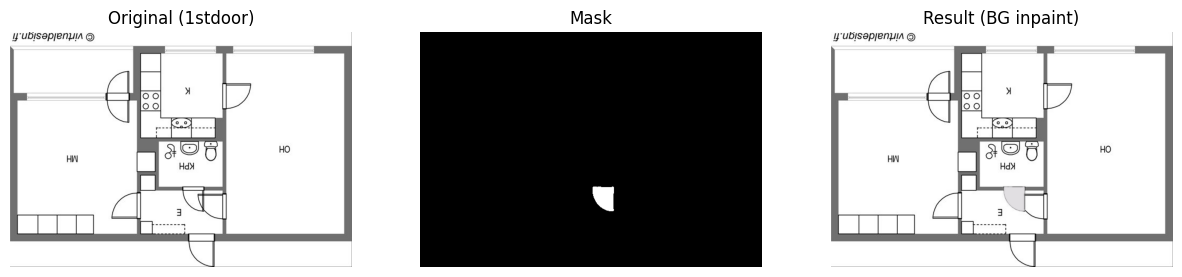

'2sdoor' -> using 2sdoor: score=0.83, area=3971.6, box=[178, 73, 223, 173]


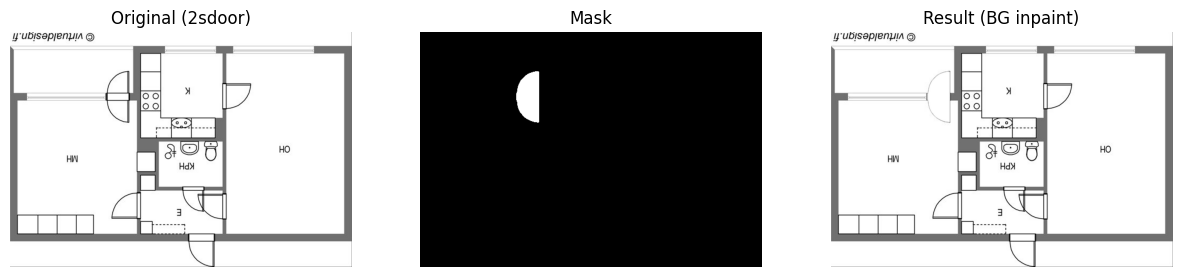

'toilet' -> using toilet: score=0.56, area=844.8, box=[319, 204, 354, 235]


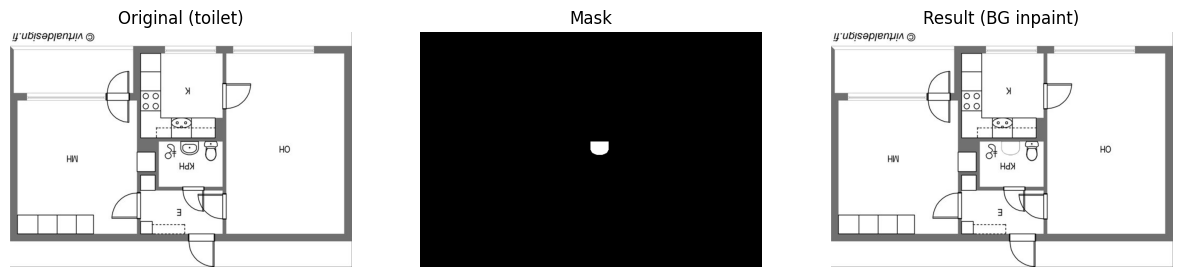

'stove' -> using stove: score=0.61, area=1066.3, box=[244, 112, 281, 149]


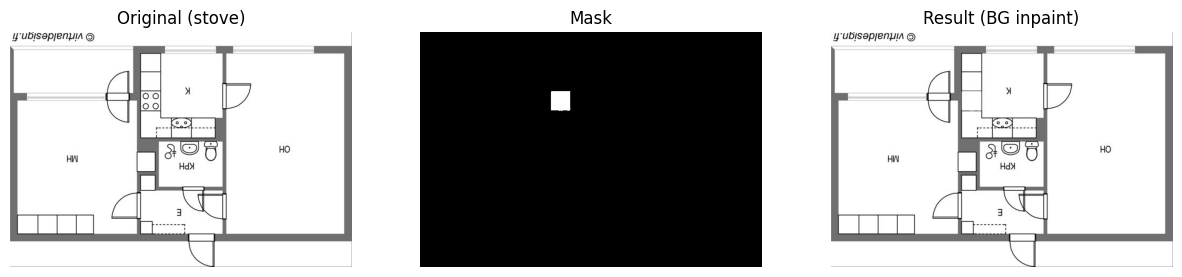

'closet' -> using closet: score=0.50, area=1004.1, box=[334, 170, 387, 195]


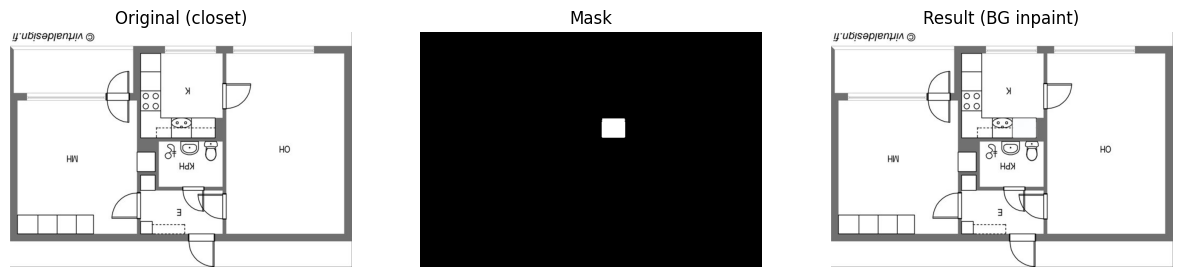

'sink' -> using sink: score=0.76, area=1000.1, box=[301, 158, 342, 189]


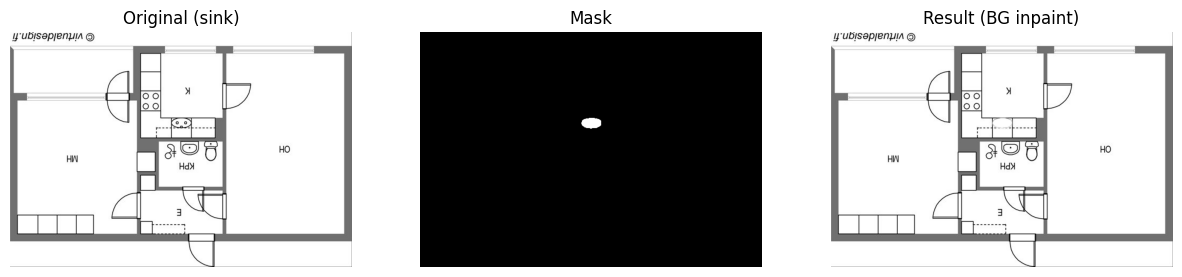


DONE Saved everything under: outputs_inpaint_from_backgrounds_all_labels


In [1]:
import os, random, gc, re
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image

from transformers import DetrImageProcessor, DetrForObjectDetection
from segment_anything import sam_model_registry, SamPredictor

# =========================
# CONFIG
# =========================
# Path to an example image for testing (relative to Code folder)
IMAGE_PATH      = r"..\Data\images_before\image_022.jpg"

# Path to the fine-tuned DETR model (relative to Code folder)
DETR_MODEL_PATH = r"..\Models\detr-finetuned-floorplans"

# Path to the SAM checkpoint (relative to Code folder)
SAM_CHECKPOINT  = r"..\Models\Sam_Checkpoint\sam_vit_h_4b8939.pth"

# Path to the backgrounds directory (relative to Code folder)
BACKGROUNDS_DIR = r"..\Data\Label_Pics_for_Synthetic_Data_Generation\backgrounds"

TARGET_LABELS = ["1stdoor", "2sdoor", "toilet", "stove", "closet", "sink"]  # run all of these
DETR_THRESH = 0.25

USE_SAM_MASK = True   # True = more precise (if SAM works), False = box mask
BOX_PAD = 2           # padding for box + SAM box

OUT_DIR = "outputs_inpaint_from_backgrounds_all_labels"
os.makedirs(OUT_DIR, exist_ok=True)

SHOW_EACH = True     # True => show 3 images per label in addition to output to folder (can be slow)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

# =========================
# Helpers
# =========================
def list_images(folder): #image types
    exts = (".png", ".jpg", ".jpeg", ".bmp", ".webp")
    if not os.path.isdir(folder):
        return []
    return [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(exts)]

def pick_background(bg_dir): #choose random background from folder to replace
    files = list_images(bg_dir)
    if not files:
        raise RuntimeError(f"No images found in {bg_dir}")
    return Image.open(random.choice(files)).convert("RGB")

def expand_box_xyxy(box, W, H, pad):
    x0, y0, x1, y1 = box
    x0 = max(0, int(x0 - pad)); y0 = max(0, int(y0 - pad))
    x1 = min(W, int(x1 + pad)); y1 = min(H, int(y1 + pad))
    return np.array([x0, y0, x1, y1], dtype=np.int32)

def draw_box(img_pil, box, color=(255, 0, 0), thickness=2):
    arr = np.array(img_pil).copy()
    x0, y0, x1, y1 = map(int, box)
    cv2.rectangle(arr, (x0, y0), (x1, y1), color, thickness)
    return Image.fromarray(arr)

def box_mask(H, W, box):
    x0, y0, x1, y1 = map(int, box)
    m = np.zeros((H, W), dtype=np.uint8)
    m[y0:y1, x0:x1] = 255
    return m

def alpha_blend_with_mask(src_rgb, bg_rgb, mask_uint8):
    """
    src_rgb, bg_rgb: uint8 HxWx3
    mask_uint8: uint8 HxW (0..255)
    """
    m = (mask_uint8.astype(np.float32) / 255.0)[..., None]
    out = (src_rgb.astype(np.float32) * (1.0 - m) + bg_rgb.astype(np.float32) * m)
    return np.clip(out, 0, 255).astype(np.uint8)

def safe_name(s: str) -> str:
    s = s.strip()
    s = re.sub(r"[^\w\-\.]+", "_", s)
    return s[:80] if len(s) > 80 else s

# =========================
# Load image once
# =========================
if not os.path.exists(IMAGE_PATH):
    raise FileNotFoundError(f"Image not found at: {IMAGE_PATH}")

image_pil = Image.open(IMAGE_PATH).convert("RGB")
W, H = image_pil.size
img_np = np.array(image_pil)

# Save original once
image_pil.save(os.path.join(OUT_DIR, "orig.png"))

# =========================
# 1) DETR detect (single forward pass)
# =========================
print(f"Loading DETR from: {DETR_MODEL_PATH}")
processor = DetrImageProcessor.from_pretrained(DETR_MODEL_PATH)
detr = DetrForObjectDetection.from_pretrained(DETR_MODEL_PATH).to(DEVICE).eval()
id2label = detr.config.id2label

inputs = processor(images=image_pil, return_tensors="pt").to(DEVICE)
with torch.no_grad():
    outputs = detr(**inputs)

target_sizes = torch.tensor([image_pil.size[::-1]], device=DEVICE)
res = processor.post_process_object_detection(
    outputs, target_sizes=target_sizes, threshold=DETR_THRESH
)[0]

# Collect all detections once
all_dets = []
for sc, lab, bx in zip(res["scores"], res["labels"], res["boxes"]):
    name = id2label[int(lab)]
    b = bx.detach().cpu().numpy()
    x0, y0, x1, y1 = b
    area = max(1.0, (x1 - x0) * (y1 - y0))
    all_dets.append((float(sc), float(area), b, name))

print(f"Found {len(all_dets)} detections above threshold={DETR_THRESH}")

# =========================
# 2) Init SAM once (optional)
# =========================
predictor = None
sam = None
if USE_SAM_MASK:
    print(f"Loading SAM from: {SAM_CHECKPOINT}")
    if not os.path.exists(SAM_CHECKPOINT):
        raise FileNotFoundError(f"SAM checkpoint not found at: {SAM_CHECKPOINT}")
        
    sam = sam_model_registry["vit_h"](checkpoint=SAM_CHECKPOINT).to(DEVICE)
    predictor = SamPredictor(sam)
    predictor.set_image(img_np, image_format="RGB")

# =========================
# 3) Loop over target labels
# =========================
for target_substr in TARGET_LABELS:
    # Filter candidates by substring match
    cands = []
    for sc, area, b, name in all_dets:
        if target_substr.lower() in name.lower():
            cands.append((sc, area, b, name))

    if not cands:
        print(f"Not found: '{target_substr}' (no detections). Skipping.")
        continue

    # pick best: highest score then largest area
    cands.sort(key=lambda x: (x[0], x[1]), reverse=True)
    best_score, best_area, best_box, best_name = cands[0]
    best_box = expand_box_xyxy(best_box, W, H, pad=BOX_PAD)

    print(f"'{target_substr}' -> using {best_name}: score={best_score:.2f}, area={best_area:.1f}, box={best_box.tolist()}")

    # Build mask
    if not USE_SAM_MASK:
        mask = box_mask(H, W, best_box)
    else:
        try:
            masks, _, _ = predictor.predict(
                box=best_box.astype(np.float32)[None, :],
                multimask_output=False
            )
            mask = (masks[0].astype(np.uint8) * 255)
        except Exception as e:
            # fall back to box mask, don't crash
            print(f"SAM failed for '{target_substr}' ({e}). Falling back to box mask.")
            mask = box_mask(H, W, best_box)

    # Background + blend
    try:
        bg_pil = pick_background(BACKGROUNDS_DIR).resize((W, H), Image.Resampling.LANCZOS)
    except Exception as e:
        print(f"Background loading failed ({e}). Skipping '{target_substr}'.")
        continue

    bg_np = np.array(bg_pil)

    # Feather edges
    mask_feather = cv2.GaussianBlur(mask, (0, 0), sigmaX=1.0)

    out_np = alpha_blend_with_mask(img_np, bg_np, mask_feather)
    out_pil = Image.fromarray(out_np)

    # Save per-label outputs
    lbl_dir = os.path.join(OUT_DIR, safe_name(target_substr))
    os.makedirs(lbl_dir, exist_ok=True)

    draw_box(image_pil, best_box).save(os.path.join(lbl_dir, "box.png"))
    Image.fromarray(mask).save(os.path.join(lbl_dir, "mask.png"))
    bg_pil.save(os.path.join(lbl_dir, "bg_used.png"))
    out_pil.save(os.path.join(lbl_dir, "result.png"))

    if SHOW_EACH:
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1); plt.title(f"Original ({target_substr})"); plt.imshow(image_pil); plt.axis("off")
        plt.subplot(1, 3, 2); plt.title("Mask"); plt.imshow(mask, cmap="gray"); plt.axis("off")
        plt.subplot(1, 3, 3); plt.title("Result (BG inpaint)"); plt.imshow(out_pil); plt.axis("off")
        plt.show()

# =========================
# Cleanup
# =========================
try:
    del inputs, outputs, detr, processor
except:
    pass

if predictor is not None:
    try:
        del predictor, sam
    except:
        pass

torch.cuda.empty_cache()
gc.collect()

print(f"\nDONE Saved everything under: {OUT_DIR}")

# Patch-Based Replacement: Sink → Stove & Toilet → Stove

This script produces **two separate edits** from the **same original floorplan**:
1. **Sink → Stove**
2. **Toilet → Stove**

It then visualizes the results as **two triplets** (2 rows × 3 images):
- **Original**
- **Stove patch (cropped)**
- **Result**

---

## Inputs

- **Floorplan image**: `IMAGE_PATH`
- **Fine-tuned DETR model**: `Models\detr-finetuned-floorplans`
- **External stove patches** (your generated symbols): `STOVE_DIR`  
  Example: `Data\Label_Pics_for_Synthetic_Data_Generation`

---

## Outputs

### Saved files (per change)
Saved under: `OUT_DIR = outputs_sink_and_toilet_to_stove`

For each change (`sink` / `toilet`) the code saves:
- `{label}_orig.png` — original image
- `{label}_box.png` — original image + detected bounding box
- `{label}_stove_patch_cropped.png` — the selected stove patch after tight-cropping
- `{label}_stove_mask_cropped.png` — ink-mask of the patch after cropping
- `{label}_result.png` — final edited image

### Visualization
The script displays:
- **Row 1**: Original → Patch → Result (**sink → stove**)
- **Row 2**: Original → Patch → Result (**toilet → stove**)

---

## Pipeline (per replacement)

### 1) Detect target object (DETR)
- Run DETR on the input image.
- Filter detections by `label == SOURCE_LABEL` (either `sink` or `toilet`).
- Keep detections above `DETR_THRESH`.
- Choose the best candidate:
  - highest score first
  - then largest area

### 2) Expand and remove the object
- Expand bounding box by `BOX_PAD` pixels.
- Fill that region with **white** (background).

### 3) Load a stove patch (external)
- Randomly select an image from `STOVE_DIR`.
- Convert patch to an **ink mask** using grayscale threshold (`INK_THRESH`):
  - pixels darker than threshold are considered “ink”

### 4) Tight-crop patch to ink
- Find the smallest bounding box around ink pixels.
- Crop both patch and mask to remove empty margins.

### 5) Resize patch to fit the target box
- Resize while keeping aspect ratio so it fits inside the detected bounding box.

### 6) Paste with alpha blending
- Use the mask as alpha:
  - ink pixels are pasted
  - background stays white
- Optional soft edges via Gaussian blur (`FEATHER_SIGMA`).

---

## Notes / Clarifications

### Are we using your generated images?
 **Yes.**  
The replacement stove symbol is taken from `STOVE_DIR` (your generated patch dataset).

### Are we cutting a stove from the original floorplan?
 **No.**  
The code only detects **where to remove** (sink/toilet).  
The stove comes from an external patch image, not from the input image.

---

## Key Parameters

- `DETR_THRESH` — detection confidence threshold  
- `BOX_PAD` — padding added around detected bounding box  
- `INK_THRESH` — ink detection threshold for patch masking  
- `FEATHER_SIGMA` — soft edge blending (0 disables)  
- `MIN_PATCH_SIZE` — ignores too-small patch images


In [ ]:
import os, gc, random
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image

from transformers import DetrImageProcessor, DetrForObjectDetection

# =========================
# CONFIG
# =========================

# 1. DETR Model Path (Relative to Code folder)
DETR_MODEL_PATH = r"..\Models\detr-finetuned-floorplans"

# 2. Image Path (Relative to Code folder)
# Pointing to an example image in your 'images_before' folder
IMAGE_PATH      = r"..\Data\images_before\image_022.jpg"

DETR_THRESH  = 0.25
BOX_PAD      = 2

# 3. Stove patches directory (Relative to Code folder)
# Pointing to the stove folder inside Label_Pics...
STOVE_DIR = r"..\Data\Label_Pics_for_Synthetic_Data_Generation\stove"

# Ink mask parameters
INK_THRESH     = 220
PATCH_DILATE   = 0
FEATHER_SIGMA  = 0.6

MIN_PATCH_SIZE = 64

OUT_DIR = "outputs_sink_and_toilet_to_stove"
os.makedirs(OUT_DIR, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

# =========================
# Helpers
# =========================
def expand_box_xyxy(box, W, H, pad):
    x0,y0,x1,y1 = box
    x0 = max(0, int(x0-pad)); y0 = max(0, int(y0-pad))
    x1 = min(W, int(x1+pad)); y1 = min(H, int(y1+pad))
    return [x0,y0,x1,y1]

def draw_box(img_pil, box, color=(255,0,0), thickness=2):
    arr = np.array(img_pil).copy()
    x0,y0,x1,y1 = map(int, box)
    cv2.rectangle(arr, (x0,y0), (x1,y1), color, thickness)
    return Image.fromarray(arr)

def list_images(folder):
    exts = (".png", ".jpg", ".jpeg", ".bmp", ".webp")
    if not os.path.exists(folder):
        print(f"Warning: Folder not found: {folder}")
        return []
    return [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(exts)]

def pick_random_patch(folder, min_size=64, tries=50):
    files = list_images(folder)
    if not files:
        raise RuntimeError(f"No images found in {folder}")
    for _ in range(tries):
        p = Image.open(random.choice(files)).convert("RGB")
        if min(p.size) >= min_size:
            return p
    return Image.open(random.choice(files)).convert("RGB")

def make_ink_mask(patch_rgb, ink_thresh=220, dilate=0):
    gray = cv2.cvtColor(patch_rgb, cv2.COLOR_RGB2GRAY)
    mask = (gray < int(ink_thresh)).astype(np.uint8) * 255

    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, k, iterations=1)

    if dilate and dilate > 0:
        k2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (dilate*2+1, dilate*2+1))
        mask = cv2.dilate(mask, k2, iterations=1)

    return mask

def tight_crop_to_mask(patch_rgb, mask, margin=2):
    ys, xs = np.where(mask > 0)
    if len(xs) == 0 or len(ys) == 0:
        return patch_rgb, mask
    x0, x1 = xs.min(), xs.max()
    y0, y1 = ys.min(), ys.max()
    x0 = max(0, x0 - margin); y0 = max(0, y0 - margin)
    x1 = min(mask.shape[1]-1, x1 + margin); y1 = min(mask.shape[0]-1, y1 + margin)
    return patch_rgb[y0:y1+1, x0:x1+1], mask[y0:y1+1, x0:x1+1]

def resize_keep_aspect(patch_rgb, mask, target_w, target_h):
    ph, pw = patch_rgb.shape[:2]
    scale = min(target_w / max(1, pw), target_h / max(1, ph))
    nw = max(1, int(round(pw * scale)))
    nh = max(1, int(round(ph * scale)))

    patch_r = cv2.resize(
        patch_rgb, (nw, nh),
        interpolation=cv2.INTER_AREA if scale < 1 else cv2.INTER_CUBIC
    )
    mask_r = cv2.resize(mask, (nw, nh), interpolation=cv2.INTER_NEAREST)
    return patch_r, mask_r

def feather_mask(mask_uint8, sigma=0.6):
    if sigma <= 0:
        return mask_uint8
    return cv2.GaussianBlur(mask_uint8, (0,0), sigmaX=float(sigma))

def apply_replace_with_stove(image_pil, source_label, save_prefix):
    """
    Detect `source_label`, remove it (white fill), paste a random stove patch.
    Returns:
      out_pil (result image),
      stove_rgb_c (cropped patch for visualization),
      box (used bbox)
    Also saves debug artifacts under OUT_DIR with prefix.
    """
    W, H = image_pil.size

    # ---- DETR detect
    inputs = processor(images=image_pil, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        outputs = detr(**inputs)

    target_sizes = torch.tensor([image_pil.size[::-1]], device=DEVICE)
    res = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=DETR_THRESH)[0]

    cands = []
    for sc, lab, bx in zip(res["scores"], res["labels"], res["boxes"]):
        name = id2label[int(lab)]
        if name != source_label:
            continue
        b = bx.detach().cpu().numpy()
        x0,y0,x1,y1 = b
        area = max(1.0, (x1-x0)*(y1-y0))
        cands.append((float(sc), float(area), b, name))

    if not cands:
        # Just a warning instead of crash, useful for testing different images
        print(f"Warning: No '{source_label}' detected in this image.")
        return image_pil, np.zeros((10,10,3), dtype=np.uint8), [0,0,1,1]

    cands.sort(key=lambda x: (x[0], x[1]), reverse=True)
    best_score, best_area, best_box, best_name = cands[0]

    box = expand_box_xyxy(best_box, W, H, pad=BOX_PAD)
    x0,y0,x1,y1 = box
    bw, bh = (x1-x0), (y1-y0)

    print(f" [{source_label}] score={best_score:.2f}, box={box}")

    # ---- remove (white)
    out = np.array(image_pil).copy()
    out[y0:y1, x0:x1] = 255

    # ---- load stove patch + mask + crop + resize + paste
    try:
        stove_pil = pick_random_patch(STOVE_DIR, min_size=MIN_PATCH_SIZE)
    except Exception as e:
        print(f"Error loading stove patch: {e}")
        return image_pil, np.zeros((10,10,3), dtype=np.uint8), box

    stove_rgb = np.array(stove_pil)

    mask = make_ink_mask(stove_rgb, ink_thresh=INK_THRESH, dilate=PATCH_DILATE)
    stove_rgb_c, mask_c = tight_crop_to_mask(stove_rgb, mask, margin=2)

    patch_r, mask_r = resize_keep_aspect(stove_rgb_c, mask_c, bw, bh)
    mask_r = feather_mask(mask_r, sigma=FEATHER_SIGMA)

    ph, pw = patch_r.shape[:2]
    px0 = x0 + (bw - pw)//2
    py0 = y0 + (bh - ph)//2

    px0 = max(0, min(W - pw, px0))
    py0 = max(0, min(H - ph, py0))

    region = out[py0:py0+ph, px0:px0+pw].astype(np.float32)
    alpha = (mask_r.astype(np.float32) / 255.0)[..., None]
    blended = region * (1.0 - alpha) + patch_r.astype(np.float32) * alpha
    out[py0:py0+ph, px0:px0+pw] = np.clip(blended, 0, 255).astype(np.uint8)

    out_pil = Image.fromarray(out)

    # ---- save debug files
    image_pil.save(os.path.join(OUT_DIR, f"{save_prefix}_orig.png"))
    draw_box(image_pil, box).save(os.path.join(OUT_DIR, f"{save_prefix}_box.png"))
    out_pil.save(os.path.join(OUT_DIR, f"{save_prefix}_result.png"))

    Image.fromarray(stove_rgb_c).save(os.path.join(OUT_DIR, f"{save_prefix}_stove_patch_cropped.png"))
    Image.fromarray(mask_c).save(os.path.join(OUT_DIR, f"{save_prefix}_stove_mask_cropped.png"))

    return out_pil, stove_rgb_c, box

# =========================
# Load DETR once
# =========================
print(f"Loading DETR from: {DETR_MODEL_PATH}")
processor = DetrImageProcessor.from_pretrained(DETR_MODEL_PATH)
detr = DetrForObjectDetection.from_pretrained(DETR_MODEL_PATH).to(DEVICE).eval()
id2label = detr.config.id2label

# =========================
# Load image once
# =========================
if not os.path.exists(IMAGE_PATH):
    raise FileNotFoundError(f"Image not found at: {IMAGE_PATH}")

print(f"Loading image: {IMAGE_PATH}")
image_pil = Image.open(IMAGE_PATH).convert("RGB")

# =========================
# Run both replacements (separately, from the same original)
# =========================
print("Processing Sink replacement...")
result_sink,   stove_crop_sink,   box_sink   = apply_replace_with_stove(image_pil, "sink",   "sink")

print("Processing Toilet replacement...")
result_toilet, stove_crop_toilet, box_toilet = apply_replace_with_stove(image_pil, "toilet", "toilet")

# cleanup model objects
del detr, processor
torch.cuda.empty_cache(); gc.collect()

# =========================
# Show: 2 triplets (sink + toilet)
# =========================
plt.figure(figsize=(18, 10))

# Triplet 1: sink -> stove
plt.subplot(2,3,1); plt.title("Original (sink)"); plt.imshow(image_pil); plt.axis("off")
plt.subplot(2,3,2); plt.title("Stove patch (cropped)"); plt.imshow(Image.fromarray(stove_crop_sink)); plt.axis("off")
plt.subplot(2,3,3); plt.title("Result (sink -> stove)"); plt.imshow(result_sink); plt.axis("off")

# Triplet 2: toilet -> stove
plt.subplot(2,3,4); plt.title("Original (toilet)"); plt.imshow(image_pil); plt.axis("off")
plt.subplot(2,3,5); plt.title("Stove patch (cropped)"); plt.imshow(Image.fromarray(stove_crop_toilet)); plt.axis("off")
plt.subplot(2,3,6); plt.title("Result (toilet -> stove)"); plt.imshow(result_toilet); plt.axis("off")

plt.tight_layout()
plt.show()

print(f" Saved artifacts to {os.path.abspath(OUT_DIR)}")
print("DONE ")

# Add Closet Near Walls (Auto-Adaptive, Non-Wall Aware)

This script **copies an existing closet symbol from the same floorplan image** and pastes it **only near walls**, while avoiding:
- text inside rooms
- other objects (non-wall ink)
- overlaps with existing symbols

It uses a **fine-tuned DETR** model to detect closets, builds **wall maps + interior mask**, separates **wall ink vs. non-wall ink**, then searches for the best valid placement.

---

##  What this script does

1. **Loads a floorplan image** (`IMAGE_PATH`)
2. Runs **DETR object detection** to find instances of `closet`
3. Chooses the best detected closet as a **template**
4. Builds:
   - `thick_map` (wall map)
   - `interior_mask` (inside the apartment, based on walls)
   - `wall_ink` (walls only)
   - `nonwall_ink` (text + furniture + symbols, excluding walls)
5. Searches for a placement that:
   - is **inside the apartment**
   - is **near walls**
   - avoids **non-wall ink** (objects/text)
   - minimizes overlaps
6. Pastes the closet and saves outputs to `OUT_DIR`

---

##  Inputs / Outputs

### Inputs
- `IMAGE_PATH`: floorplan PNG/JPG
- `DETR_MODEL_PATH`: folder containing the fine-tuned DETR model

### Outputs (saved under `OUT_DIR`)
- `result.png` — final floorplan with a pasted closet  
- `result_box.png` — debug: source closet (blue box) + placed closet (red box)
- `thick_walls_clean.png` — detected walls map
- `interior_mask.png` — computed interior region
- `nonwall_ink.png` — text/objects ink excluding walls
- `wall_ink.png` — wall ink mask
- `placement_mask_band_*.png` — wall-band placement masks per band tested



In [ ]:
import os, gc
import numpy as np
import cv2
import torch
from PIL import Image
from transformers import DetrImageProcessor, DetrForObjectDetection

# =========================
# CONFIG
# =========================
# Using relative paths for better portability
IMAGE_PATH      = r"..\Data\images_before\image_008.jpg"
DETR_MODEL_PATH = r"..\Models\detr-finetuned-floorplans"

TARGET_LABEL = "closet"
DETR_THRESH  = 0.20

OUT_DIR = r"outputs_add_closet_wall_only_v2"
os.makedirs(OUT_DIR, exist_ok=True)

# Wall detection kernel size
WALL_KERNEL = 11

# Scanning parameters
MARGIN = 10
STRIDE = 4

# Interior constraint (closet ink must be inside the detected room)
MIN_INK_INSIDE_FRAC = 0.99

# Coarse "busy" filter - ignores walls now, stricter on other objects
MAX_NONWALL_BLACK_FRAC = 0.06 

# Overlap avoidance settings
EXISTING_DILATE = 3
MAX_OVERLAP_PIXELS_BASE = 10
MAX_OVERLAP_FRAC_BASE   = 0.03

# Keep-away ring settings (distance from text/other objects)
RING_DILATE = 10
MAX_RING_OVERLAP_PIXELS = 25
MAX_RING_OVERLAP_FRAC   = 0.03

# Mask blending softness
FEATHER_SIGMA = 0.6

# Template filtering parameters
MIN_TEMPLATE_SIZE = 18
MAX_TEMPLATE_REL = 0.45
BOX_PAD = 2

# Near-wall bands (distance to walls to check)
BANDS = [10, 14, 18, 24, 30, 40, 55]

# Adaptive overlap relaxation
OV_PIX_LIST  = [MAX_OVERLAP_PIXELS_BASE, 16, 24, 36]
OV_FRAC_LIST = [MAX_OVERLAP_FRAC_BASE,   0.04, 0.06, 0.08]

# Must be touching the wall constraints
WALL_TOUCH_MAX_DIST = 3.0
MIN_WALL_TOUCH_FRAC = 0.03

# Thick-wall cleanup thresholds
THICK_MIN_AREA       = 2500
THICK_MIN_LONG_SIDE  = 160
THICK_MIN_SHORT_SIDE = 6

# Wall/Non-wall separation settings
WALL_INK_DILATE = 3   # Expand walls slightly to cleanly separate from other ink

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

# =========================
# Helpers
# =========================
def expand_box_xyxy(box, W, H, pad):
    x0,y0,x1,y1 = box
    x0 = max(0, int(x0-pad)); y0 = max(0, int(y0-pad))
    x1 = min(W, int(x1+pad)); y1 = min(H, int(y1+pad))
    return [x0,y0,x1,y1]

def filter_thick_map_components(thick_map, min_area=1500, min_long_side=120, min_short_side=6):
    # Filters out small noise from the wall map
    bw = (thick_map > 0).astype(np.uint8)
    num, labels, stats, _ = cv2.connectedComponentsWithStats(bw, connectivity=8)
    out = np.zeros_like(bw)
    for i in range(1, num):
        x, y, w, h, area = stats[i]
        long_side = max(w, h)
        short_side = min(w, h)
        if area < min_area: 
            continue
        if long_side < min_long_side:
            continue
        if short_side < min_short_side:
            continue
        out[labels == i] = 1
    return (out * 255).astype(np.uint8)

def build_line_maps(img_bgr, wall_kernel):
    # Extracts potential walls and cleans them up
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    _, bin_inv = cv2.threshold(gray, 235, 255, cv2.THRESH_BINARY_INV) 

    k = cv2.getStructuringElement(cv2.MORPH_RECT, (wall_kernel, wall_kernel))
    thick = cv2.morphologyEx(bin_inv, cv2.MORPH_CLOSE, k, iterations=1)
    thick = cv2.erode(thick, np.ones((3,3), np.uint8), iterations=1)

    thick_clean = filter_thick_map_components(
        thick,
        min_area=THICK_MIN_AREA,
        min_long_side=THICK_MIN_LONG_SIDE,
        min_short_side=THICK_MIN_SHORT_SIDE
    )
    return bin_inv, thick_clean

def build_interior_from_walls(thick_map, close_gaps=13, wall_dilate=2):
    # Floods the image to find the "interior" of the floorplan
    H, W = thick_map.shape[:2]
    walls = (thick_map > 0).astype(np.uint8) * 255

    if wall_dilate > 0:
        k = cv2.getStructuringElement(cv2.MORPH_RECT, (2*wall_dilate+1, 2*wall_dilate+1))
        walls = cv2.dilate(walls, k, iterations=1)

    k2 = cv2.getStructuringElement(cv2.MORPH_RECT, (close_gaps, close_gaps))
    walls_closed = cv2.morphologyEx(walls, cv2.MORPH_CLOSE, k2, iterations=1)

    free = cv2.bitwise_not(walls_closed)
    ff = free.copy()
    mask = np.zeros((H+2, W+2), dtype=np.uint8)

    # Floodfill from corners
    for seed in [(0,0), (W-1,0), (0,H-1), (W-1,H-1)]:
        if ff[seed[1], seed[0]] == 255:
            cv2.floodFill(ff, mask, seedPoint=seed, newVal=0)

    interior = ff
    return interior, walls_closed

def build_placement_mask(interior_mask, thick_map, wall_band):
    # Creates a mask of valid placement areas near walls
    thick_bin = (thick_map > 0).astype(np.uint8)
    dist = cv2.distanceTransform(1 - thick_bin, cv2.DIST_L2, 3)
    near_wall = (dist <= wall_band).astype(np.uint8) * 255
    placement = cv2.bitwise_and(interior_mask, near_wall)
    return placement

def mask_from_crop_nonwhite(crop_bgr, feather_sigma):
    # Creates a mask from the non-white pixels of a crop
    gray = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2GRAY)
    hard = cv2.inRange(gray, 0, 245)
    hard = cv2.morphologyEx(hard, cv2.MORPH_CLOSE, np.ones((3,3), np.uint8), iterations=1)
    soft = hard.copy()
    if feather_sigma and feather_sigma > 0:
        soft = cv2.GaussianBlur(soft, (0,0), sigmaX=float(feather_sigma))
    return hard, soft

def alpha_paste(base_bgr, crop_bgr, mask_uint8, x, y):
    # Pastes a crop onto the base image using alpha blending
    h, w = crop_bgr.shape[:2]
    roi = base_bgr[y:y+h, x:x+w]
    m = (mask_uint8.astype(np.float32) / 255.0)[..., None]
    out = roi.astype(np.float32) * (1.0 - m) + crop_bgr.astype(np.float32) * m
    base_bgr[y:y+h, x:x+w] = np.clip(out, 0, 255).astype(np.uint8)
    return base_bgr

def resize_template(template, mask_hard, mask_soft, scale):
    # Resizes the template and its masks
    h, w = template.shape[:2]
    nw = max(8, int(w * scale))
    nh = max(8, int(h * scale))
    t2  = cv2.resize(template,  (nw, nh), interpolation=cv2.INTER_AREA)
    mh2 = cv2.resize(mask_hard, (nw, nh), interpolation=cv2.INTER_NEAREST)
    ms2 = cv2.resize(mask_soft, (nw, nh), interpolation=cv2.INTER_NEAREST)
    return t2, mh2, ms2

def choose_template_highest_score(templates):
    templates.sort(key=lambda t: t["score"], reverse=True)
    return templates[0]

def make_ring_mask(mh_uint8, ring_dilate):
    # Creates a ring mask around the object for spacing checks
    mh = (mh_uint8 > 0).astype(np.uint8)
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*ring_dilate+1, 2*ring_dilate+1))
    dil = cv2.dilate(mh, k, iterations=1)
    ring = (dil > 0).astype(np.uint8) - (mh > 0).astype(np.uint8)
    ring[ring < 0] = 0
    return ring

def find_best_spot_wall_only(
    interior_mask, placement_mask,
    thick_map,
    all_ink, nonwall_ink, 
    template_mask_hard, roi_w, roi_h,
    margin, stride,
    max_nonwall_black_frac,
    existing_dilate,
    max_overlap_pixels, max_overlap_frac,
    wall_band,
    min_ink_inside_frac,
    wall_touch_max_dist, min_wall_touch_frac,
    ring_dilate, max_ring_overlap_pixels, max_ring_overlap_frac
):
    H, W = interior_mask.shape[:2]

    # Dilate NON-WALL ink for collision / ring tests
    if existing_dilate and existing_dilate > 0:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*existing_dilate+1, 2*existing_dilate+1))
        nonwall_ink_dil = cv2.dilate(nonwall_ink, k, iterations=1)
    else:
        nonwall_ink_dil = nonwall_ink

    # Distance map to WALLS
    thick_bin = (thick_map > 0).astype(np.uint8)
    dist_to_wall = cv2.distanceTransform(1 - thick_bin, cv2.DIST_L2, 3)

    mh = (template_mask_hard > 0).astype(np.uint8)
    mh_sum = int(mh.sum())
    if mh_sum == 0:
        return None

    ring = make_ring_mask(template_mask_hard, ring_dilate)
    ring_sum = int(ring.sum()) if ring is not None else 0

    best = None
    best_score = -1e18

    # Scan grid for best placement
    for y in range(margin, H - roi_h - margin, stride):
        for x in range(margin, W - roi_w - margin, stride):

            cx = x + roi_w // 2
            cy = y + roi_h // 2
            if placement_mask[cy, cx] == 0:
                continue

            # Busy check ONLY on non-wall ink
            roi_nonwall = nonwall_ink[y:y+roi_h, x:x+roi_w]
            nonwall_black_frac = float((roi_nonwall > 0).mean())
            if nonwall_black_frac > max_nonwall_black_frac:
                continue

            # 1) Closet ink inside interior check
            roi_int = (interior_mask[y:y+roi_h, x:x+roi_w] > 0).astype(np.uint8)
            inside_on_ink = roi_int[mh > 0]
            if inside_on_ink.size == 0:
                continue
            ink_inside_frac = float(inside_on_ink.mean())
            if ink_inside_frac < min_ink_inside_frac:
                continue

            # 2) Near wall check (mean dist + touch)
            roi_dist = dist_to_wall[y:y+roi_h, x:x+roi_w]
            ink_dist = roi_dist[mh > 0]
            if ink_dist.size == 0:
                continue
            if float(ink_dist.mean()) > float(wall_band):
                continue
            touch_frac = float((ink_dist <= wall_touch_max_dist).mean())
            if touch_frac < min_wall_touch_frac:
                continue

            # 3) Overlap UNDER closet ink — only against NON-WALL ink
            roi_exist = (nonwall_ink_dil[y:y+roi_h, x:x+roi_w] > 0).astype(np.uint8)
            overlap_pixels = int((roi_exist * mh).sum())
            if overlap_pixels > max_overlap_pixels:
                continue
            overlap_frac = overlap_pixels / float(mh_sum)
            if overlap_frac > max_overlap_frac:
                continue

            # 4) Ring keep-away — only against NON-WALL ink
            ring_overlap = 0
            ring_overlap_frac = 0.0
            if ring_sum > 0:
                ring_overlap = int((roi_exist * ring).sum())
                if ring_overlap > max_ring_overlap_pixels:
                    continue
                ring_overlap_frac = ring_overlap / float(ring_sum)
                if ring_overlap_frac > max_ring_overlap_frac:
                    continue

            # Calculate score
            score = (
                (1.0 - nonwall_black_frac) * 1.5 +
                (1.0 - overlap_frac) * 4.0 +
                (1.0 - ring_overlap_frac) * 2.5 +
                (1.0 - min(1.0, float(ink_dist.mean()) / float(wall_band))) * 1.5 +
                touch_frac * 1.0 +
                ink_inside_frac * 0.5
            )

            if score > best_score:
                best_score = score
                best = (x, y, nonwall_black_frac, ink_inside_frac, overlap_frac, overlap_pixels,
                        float(ink_dist.mean()), touch_frac, ring_overlap)

    return best

# =========================
# 1) Load Image
# =========================
if not os.path.exists(IMAGE_PATH):
    raise FileNotFoundError(f"Image not found at {IMAGE_PATH}")

img_pil = Image.open(IMAGE_PATH).convert("RGB")
img_bgr = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
H, W = img_bgr.shape[:2]

# =========================
# 2) DETR Template Extraction
# =========================
print(f"Loading DETR model from: {DETR_MODEL_PATH}")
processor = DetrImageProcessor.from_pretrained(DETR_MODEL_PATH)
detr = DetrForObjectDetection.from_pretrained(DETR_MODEL_PATH).to(DEVICE).eval()
id2label = detr.config.id2label

inputs = processor(images=img_pil, return_tensors="pt").to(DEVICE)
with torch.no_grad():
    outputs = detr(**inputs)

target_sizes = torch.tensor([img_pil.size[::-1]], device=DEVICE)
res = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=DETR_THRESH)[0]

del detr, processor, inputs, outputs
torch.cuda.empty_cache(); gc.collect()

templates = []
for sc, lab, bx in zip(res["scores"], res["labels"], res["boxes"]):
    if id2label[int(lab)] != TARGET_LABEL:
        continue
    b = expand_box_xyxy(bx.detach().cpu().numpy(), W, H, BOX_PAD)
    x0,y0,x1,y1 = map(int, b)
    crop = img_bgr[y0:y1, x0:x1].copy()
    if crop.size == 0:
        continue
    th, tw = crop.shape[:2]
    if th < MIN_TEMPLATE_SIZE or tw < MIN_TEMPLATE_SIZE:
        continue
    if tw > W * MAX_TEMPLATE_REL or th > H * MAX_TEMPLATE_REL:
        continue
    mh, ms = mask_from_crop_nonwhite(crop, FEATHER_SIGMA)
    templates.append({"crop": crop, "mask_hard": mh, "mask_soft": ms, "box": (x0,y0,x1,y1), "score": float(sc)})

if not templates:
    print(f"Warning: No closets detected with threshold {DETR_THRESH}. Exiting.")
    exit()

canon = choose_template_highest_score(templates)
template = canon["crop"]
template_mask_hard = canon["mask_hard"]
template_mask_soft = canon["mask_soft"]
sx0,sy0,sx1,sy1 = canon["box"]
print(f"Selected Template: score={canon['score']:.2f}, size={template.shape[1]}x{template.shape[0]}")

# Calculate proportional scaling
ws = [t["box"][2] - t["box"][0] for t in templates]
hs = [t["box"][3] - t["box"][1] for t in templates]
med_w, med_h = float(np.median(ws)), float(np.median(hs))
base_h, base_w = template.shape[:2]
target_scale = min(med_w / max(1.0, base_w), med_h / max(1.0, base_h))
target_scale = max(0.5, min(1.2, float(target_scale)))
SCALES = [target_scale * s for s in [0.9, 1.0, 1.1]]
print(f"Scale Settings: target_scale={target_scale:.3f}")

# =========================
# 3) Build Maps
# =========================
bin_inv_lines, thick_map = build_line_maps(img_bgr, WALL_KERNEL)
interior_mask, walls_closed = build_interior_from_walls(thick_map, close_gaps=13, wall_dilate=2)

# Separate wall ink from non-wall ink
all_ink = (bin_inv_lines > 0).astype(np.uint8) * 255
wall_ink = (thick_map > 0).astype(np.uint8) * 255

if WALL_INK_DILATE > 0:
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*WALL_INK_DILATE+1, 2*WALL_INK_DILATE+1))
    wall_ink = cv2.dilate(wall_ink, k, iterations=1)

nonwall_ink = cv2.bitwise_and(all_ink, cv2.bitwise_not(wall_ink))

# Save debug images
cv2.imwrite(os.path.join(OUT_DIR, "orig.png"), cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
cv2.imwrite(os.path.join(OUT_DIR, "bin_inv_lines.png"), bin_inv_lines)
cv2.imwrite(os.path.join(OUT_DIR, "thick_walls_clean.png"), thick_map)
cv2.imwrite(os.path.join(OUT_DIR, "interior_mask.png"), interior_mask)
cv2.imwrite(os.path.join(OUT_DIR, "wall_ink.png"), wall_ink)
cv2.imwrite(os.path.join(OUT_DIR, "nonwall_ink.png"), nonwall_ink)

# =========================
# 4) Search for Placement
# =========================
best = None
chosen_scale = None
chosen_band = None
chosen_ov_pix = None
chosen_ov_frac = None

print("Searching for placement...")

for band in BANDS:
    placement_mask = build_placement_mask(interior_mask, thick_map, wall_band=band)
    
    # Save debug mask for this band
    cv2.imwrite(os.path.join(OUT_DIR, f"placement_mask_band_{band}.png"), placement_mask)

    if int((placement_mask > 0).sum()) < 500:
        continue

    for ov_pix in OV_PIX_LIST:
        for ov_frac in OV_FRAC_LIST:
            for sc in SCALES:
                t_try, mh_try, ms_try = resize_template(template, template_mask_hard, template_mask_soft, sc)
                roi_h, roi_w = t_try.shape[:2]

                best_try = find_best_spot_wall_only(
                    interior_mask=interior_mask,
                    placement_mask=placement_mask,
                    thick_map=thick_map,
                    all_ink=all_ink,
                    nonwall_ink=nonwall_ink,
                    template_mask_hard=mh_try,
                    roi_w=roi_w, roi_h=roi_h,
                    margin=MARGIN, stride=STRIDE,
                    max_nonwall_black_frac=MAX_NONWALL_BLACK_FRAC,
                    existing_dilate=EXISTING_DILATE,
                    max_overlap_pixels=ov_pix,
                    max_overlap_frac=ov_frac,
                    wall_band=band,
                    min_ink_inside_frac=MIN_INK_INSIDE_FRAC,
                    wall_touch_max_dist=WALL_TOUCH_MAX_DIST,
                    min_wall_touch_frac=MIN_WALL_TOUCH_FRAC,
                    ring_dilate=RING_DILATE,
                    max_ring_overlap_pixels=MAX_RING_OVERLAP_PIXELS,
                    max_ring_overlap_frac=MAX_RING_OVERLAP_FRAC
                )

                if best_try is not None:
                    best = best_try
                    template, template_mask_hard, template_mask_soft = t_try, mh_try, ms_try
                    chosen_scale = sc
                    chosen_band = band
                    chosen_ov_pix = ov_pix
                    chosen_ov_frac = ov_frac
                    break
            if best is not None: break
        if best is not None: break
    if best is not None: break

if best is None:
    raise RuntimeError(
        "No suitable placement found.\n"
        "Try relaxing these parameters:\n"
        "1) MAX_NONWALL_BLACK_FRAC\n"
        "2) RING_DILATE\n"
        "3) MIN_WALL_TOUCH_FRAC\n"
        "4) Add larger BANDS"
    )

px, py, nonwall_black_frac, ink_inside_frac, ov_f, ov_p, mean_dist, touch_frac, ring_overlap = best
roi_h, roi_w = template.shape[:2]

print(f"Placement Found: ({px},{py})")
print(f"  Band: {chosen_band}, Scale: {chosen_scale:.3f}")
print(f"  Non-wall Black Frac: {nonwall_black_frac:.3f}")
print(f"  Ink Inside Frac: {ink_inside_frac:.3f}")

# =========================
# 5) Paste and Save
# =========================
out = img_bgr.copy()
out = alpha_paste(out, template, template_mask_soft, px, py)

viz = out.copy()
cv2.rectangle(viz, (sx0,sy0), (sx1,sy1), (255,0,0), 2)
cv2.rectangle(viz, (px,py), (px+roi_w, py+roi_h), (0,0,255), 2)

cv2.imwrite(os.path.join(OUT_DIR, "result.png"), out)
cv2.imwrite(os.path.join(OUT_DIR, "result_box.png"), viz)

print(f"Done. Results saved to: {os.path.abspath(OUT_DIR)}")

DEVICE: cuda
✅ Template: box=(581, 427, 611, 490) score=0.92 size=30x63
✅ Scale policy: target_scale=1.000, SCALES=['0.900', '1.000', '1.100']
✅ Placement: (446,86) band=18 scale=0.900 nonwallBlack=0.000 inkInside=1.000 overlap=0.0000 px=0 meanWallDist=9.29 touchFrac=0.081 ringInk=0
✅ DONE. Saved to: .\outputs_add_closet_wall_only_v2
